Test whether neg voja with recurrence can actually learn an association

In [18]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (BasicVecFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

## Setup

In [2]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [10]:
with h5py.File(os.path.join(data_path, "bcm_rec_match_weights.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [3]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [4]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [5]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [6]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [24]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(5e-3))
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] > 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:29.                                                                              


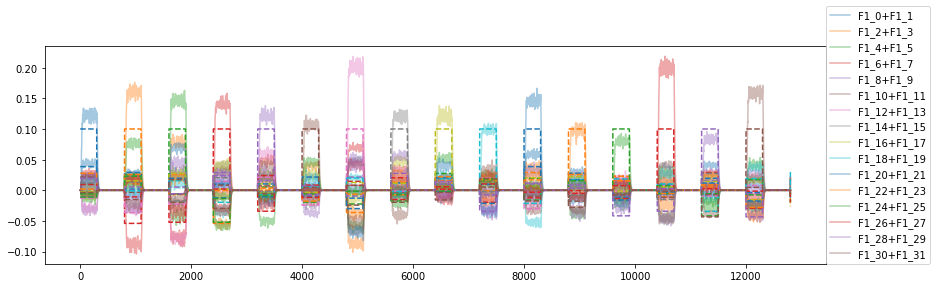

In [32]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

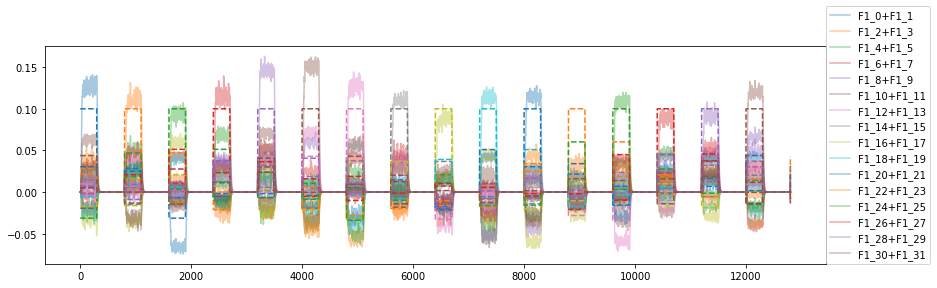

In [33]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

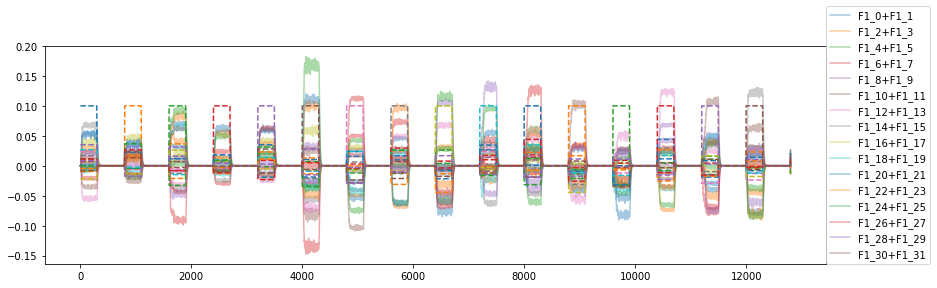

In [38]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][foil1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))